<a href="https://colab.research.google.com/github/VindhyaSRajan/Master-s-Thesis/blob/master/EDA_OpenI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


##Data Exploration

In [0]:
!pip install gensim
!pip install bs4
!pip install pyLDAvis
!pip install warnings

In [50]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)  # to view entire text in any column
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import string
import gzip
from pprint import pprint

from bs4 import BeautifulSoup
import nltk
from nltk import FreqDist
nltk.download('stopwords') 
from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer  # alternative lemmatizer
# lemma = WordNetLemmatizer()

import spacy
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

import pyLDAvis
import pyLDAvis.gensim   # for visualizing found topics

import os

from numpy import array
import nltk
nltk.download('wordnet')

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)  # suppressing deprecation warnings when running gensim LDA

#from specialmaps import CONTRACTION_MAP
#from collections import defaultdict

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [6]:
df = pd.read_csv('/content/drive/My Drive/OpeniReports.csv', nrows  = 100000, error_bad_lines = False)
print('Shape of the actual data is ',df.shape)
df.columns

Shape of the actual data is  (7574, 10)


Index(['Unnamed: 0', 'uId', 'pmcId', 'Owner', 'parentImage_id', 'Comparison',
       'Indication', 'Findings', 'Impression', 'Major'],
      dtype='object')

In [8]:
df = df[['uId','parentImage_id','Comparison','Indication','Findings','Impression','Major']]
df.sample(5)

,uId,parentImage_id,Comparison,Indication,Findings,Impression,Major
5533,CXR1916,CXR1916_IM-0595-1001,Chest radiograph XXXX.,COPD,There is stable left costophrenic XXXX blunting. The patient has undergone prior left lobectomy. There are chronic appearing right basilar interstitial markings. Heart size normal. No visualized pneumothorax. There is stable appearing left upper and right upper lobe bullous disease.,1. No acute cardiopulmonary findings. 2. Unchanged chronic appearance of the left lung.,Costophrenic Angle/left/blunted
260,CXR3871,CXR3871_IM-1964-2001,NaN,HISTORY OF HISTOPLASMOSIS XXXX ON TNF - XXXX XXXX - XXXX XXXX,NaN,No comparison chest x-XXXX. Well-expanded and clear lungs. Mediastinal contour within normal limits. No acute cardiopulmonary abnormality identified.,normal
549,CXR2813,CXR2813_IM-1239-1001,Two-view chest from XXXX.,XXXX-year-old female chest pain.,Heart size within normal limits. No focal airspace disease. No pneumothorax or effusion. Mild degenerative change in the thoracic spine.,No acute cardiopulmonary findings.,Thoracic Vertebrae/degenerative/mild
1134,CXR2296,CXR2296_IM-0876-2001,None.,XXXX-year-old male with chest pain.,"The heart is normal in size with normal appearance of the cardiomediastinal silhouette. There is a hiatal hernia with soft tissue projecting behind the mediastinum. The lungs are clear without focal airspace opacity, pleural effusion, pneumothorax. The osseous structures are intact.",1. No acute cardiopulmonary finding. 2. Hiatal hernia.,"Hernia, Hiatal"
3311,CXR3268,CXR3268_IM-1551-1001,"Radiograph Chest PA and Lateral XXXX, XXXX.",Shortness of breath.,The heart is normal in size and contour. There is no mediastinal widening. The lungs are clear bilaterally. No large pleural effusion or pneumothorax. The XXXX are intact.,No acute cardiopulmonary abnormalities.,normal


In [0]:
# function to plot most frequent terms. This is used to gauge the quality of text processing
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top n most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

In [14]:
df = df.dropna(subset = ['Findings'])
print('Now the shape is: ',df.shape) #shape should come around (6561,7)
df.sample(5)

Now the shape is:  (6561, 7)


,uId,parentImage_id,Comparison,Indication,Findings,Impression,Major
2914,CXR3709,CXR3709_IM-1852-4001,None.,History of aortic dissection.,"The mediastinal silhouette is widened with overlying sternotomy XXXX. The heart size is normal. The lungs are clear without evidence of effusion, infiltrate or pneumothorax. Visualized bony structures are intact with no acute abnormalities.","1. Wide mediastinal XXXX, consistent with history of aortic dissection. 2. Otherwise normal chest x-XXXX.",Mediastinum/prominent
1204,CXR129,CXR129_IM-0189-2001,None available,Hemoptysis,"The cardiomediastinal silhouette is within normal limits for size and contour. The lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. Osseous structures are within normal limits for patient age..",1. No acute radiographic cardiopulmonary process.,normal
2734,CXR3402,CXR3402_IM-1646-2001,XXXX,XXXX-year-old female with chest pain,"The heart size and mediastinal contours appear within normal limits. No focal airspace consolidation, pleural effusion or pneumothorax. Scattered calcified granulomas bilaterally. No acute bony abnormalities.",No acute cardiopulmonary findings.,Calcified Granuloma/bilateral/scattered/multiple
3769,CXR858,CXR858_IM-2379-1001,None.,XXXX. XXXX posterior chest pain.,"Frontal and lateral views of the chest show normal size and configuration of the cardiac silhouette. There is evidence of previous granulomatous disease. Normal mediastinal contour, pulmonary XXXX and vasculature, central airways and lung volumes. No pleural effusion.","No acute or active cardiac, pulmonary or pleural disease.",Granulomatous Disease
2599,CXR3039,CXR3039_IM-1412-2001,None.,XXXX vehicle accident. Mid chest pain from airbag.,Normal heart size. Clear lungs. No pneumothorax or large pleural effusion.,No acute cardiopulmonary findings.,normal


Top 10 :
        uId  FindingsCount
0  CXR1303  5            
1  CXR3359  4            
2  CXR2243  4            
3  CXR3965  4            
4  CXR2084  4            
5  CXR3932  4            
6  CXR3566  4            
7  CXR1102  4            
8  CXR2097  4            
9  CXR2560  4             

count    3425.000000
mean     1.915620   
std      0.439245   
min      1.000000   
25%      2.000000   
50%      2.000000   
75%      2.000000   
max      5.000000   
Name: FindingsCount, dtype: float64
Top 10 :
        uId  MajorCount
0  CXR1303  5         
1  CXR3359  4         
2  CXR2243  4         
3  CXR3965  4         
4  CXR2084  4         
5  CXR3932  4         
6  CXR3566  4         
7  CXR1102  4         
8  CXR2097  4         
9  CXR2560  4          

count    3425.000000
mean     1.915620   
std      0.439245   
min      1.000000   
25%      2.000000   
50%      2.000000   
75%      2.000000   
max      5.000000   
Name: MajorCount, dtype: float64


(-1, 100)

<Figure size 576x720 with 0 Axes>

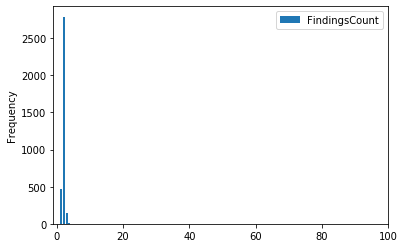

<Figure size 576x720 with 0 Axes>

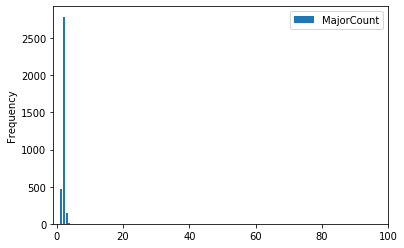

In [19]:
#OpenI Data
# number of reports, number of associated Findings for each X-Ray
findings_count = df.groupby('uId').agg({'Findings':'count'}).sort_values(by = 'Findings', ascending = False)
findings_count = findings_count.reset_index()
findings_count = findings_count.rename({'Findings':'FindingsCount'}, axis = 'columns')
print('Top 10 :\n', findings_count.head(10),'\n')
print(findings_count.FindingsCount.describe())
plt.figure(figsize=(8,10))

# a few products are much more highly reviewed than the rest, zoom in to x < 200
findings_count.plot.hist(by='FindingsCount', bins = 5, rwidth = 0.8)  
plt.xlim([-1,100])   # enmt: log y axis


# number of reports, number of associated Major for each X-Ray
major_count = df.groupby('uId').agg({'Major':'count'}).sort_values(by = 'Major', ascending = False)
major_count = major_count.reset_index()
major_count = major_count.rename({'Major':'MajorCount'}, axis = 'columns')
print('Top 10 :\n', major_count.head(10),'\n')
print(major_count.MajorCount.describe())
plt.figure(figsize=(8,10))

# a few products are much more highly reviewed than the rest, zoom in to x < 200
major_count.plot.hist(by='MajorCount', bins = 5, rwidth = 0.8)  
plt.xlim([-1,100])   # enmt: log y axis

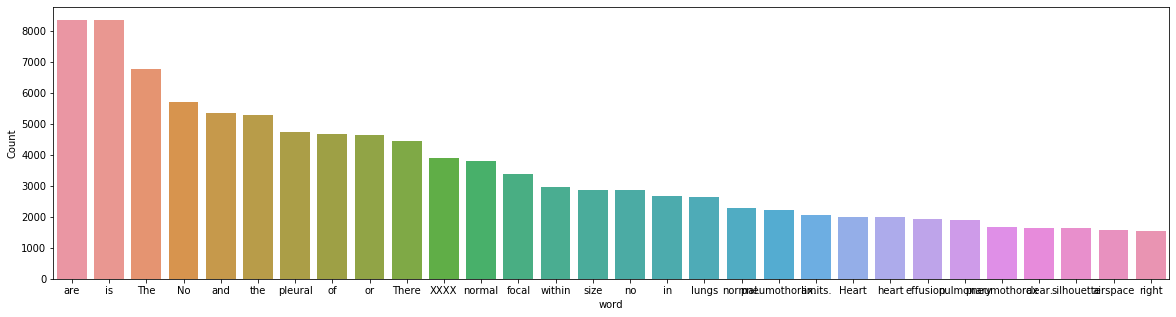

In [20]:
freq_words(list(df['Findings']))

In [0]:
# functions for text cleaning and pre-processing

punc_char = set(string.punctuation)

def remove_punctuation(rev):
    # remove punctuation from the input string rev
    return ''.join([ch for ch in rev if ch not in punc_char])

stop_words = stopwords.words('english')
stop_words.extend(['would','dont','cant','should','it.','(',')','-','one','!','"',',','.'])  

def remove_stopwords(rev):
    # rev is a review text, one string
    rev_new = " ".join([i for i in rev.split() if i not in stop_words])
    return rev_new

nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(rev): 
    # lemmatize input string rev, i.e. reduce all forms of a word to the lemma
    doc = nlp(" ".join(rev.split()))
    return " ".join([token.lemma_ for token in doc])

def lemmatization_tag(rev, tags = ['NOUN', 'ADJ']): # filter noun and adjective
    doc = nlp(" ".join(rev.split()))
    return " ".join([token.lemma_ for token in doc if token.pos_ in tags])

def remove_num(s):
    # s is a string, e.g. an entire review text
    return ''.join([i for i in s if not i.isdigit()])

In [25]:
# contraction expansion tests
print("\n Printing the samples from the column Findings \n")
print(df['Findings'].sample(n=5, random_state = 0))
print("\n")
print("\n Now printing the text from the column Major \n")
print(df['Major'].sample(n=5, random_state = 0))
print("\n")



 Printing the samples from the column Findings 

2596    There is a calcified granuloma in the left upper lung zone. The lungs are otherwise clear. There is hyperinflation. The heart and mediastinum are normal. The skeletal structures and soft tissues are normal for age.                                                                                                                              
5107    The cardiomediastinal silhouette is within normal limits. Calcified right lower lobe granuloma. No focal airspace consolidation.. No visualized pneumothorax or large pleural effusion. No acute bony abnormalities.                                                                                                                                
3583    The heart and mediastinum are unremarkable. There is tortuosity of the aorta, compatible with atherosclerosis. Low lung volumes. Minimal XXXX opacities within the lung bases, XXXX subsegmental atelectasis. The lungs are clear without infiltrate

In [0]:
df.loc[:,'Findings_no_punc'] = [remove_punctuation(r) for r in df['Findings']]
df.loc[:,'Major_no_punc'] = [remove_punctuation(r) for r in df['Major']]
#df[:'review_no_punc']

In [29]:
df.shape

(6561, 9)

In [0]:
df.loc[:,'Findings_no_stopwords'] = [remove_stopwords(r.lower()) for r in df['Findings_no_punc']]

In [32]:
print(df['Findings'].sample(n=5, random_state = 0),'\n')
print("\n  After removing stop words and punctuations  \n")
print(df['Findings_no_punc'].sample(n=5, random_state = 0),'\n')

2596    There is a calcified granuloma in the left upper lung zone. The lungs are otherwise clear. There is hyperinflation. The heart and mediastinum are normal. The skeletal structures and soft tissues are normal for age.                                                                                                                              
5107    The cardiomediastinal silhouette is within normal limits. Calcified right lower lobe granuloma. No focal airspace consolidation.. No visualized pneumothorax or large pleural effusion. No acute bony abnormalities.                                                                                                                                
3583    The heart and mediastinum are unremarkable. There is tortuosity of the aorta, compatible with atherosclerosis. Low lung volumes. Minimal XXXX opacities within the lung bases, XXXX subsegmental atelectasis. The lungs are clear without infiltrate. There is no effusion or pneumothorax.           

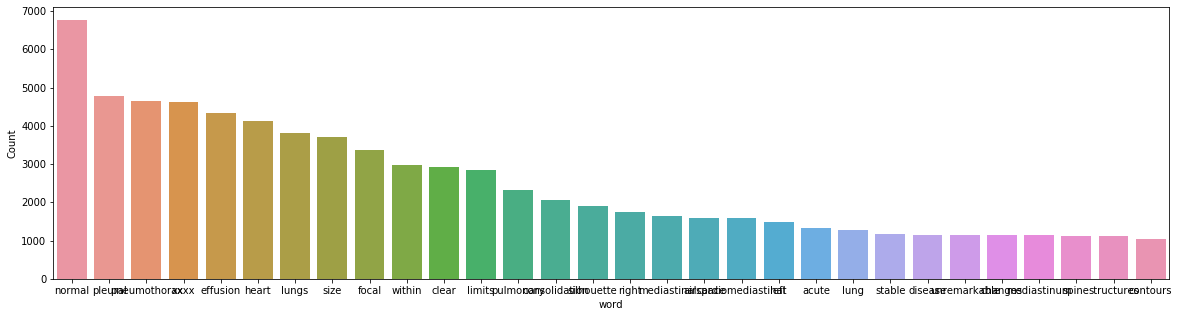

In [34]:
freq_words(df['Findings_no_stopwords'])

In [0]:
# lemmatize, this is a relatively slow preprocessing step 
df.loc[:,'Findings_lemmatized'] = df['Findings_no_stopwords'].apply(lemmatization)

In [0]:
# run remove stop words again because the lemmatization process generates more stop words
df.loc[:,'Findings_lemmatized'] = df['Findings_lemmatized'].apply(remove_stopwords)

In [0]:
# remove numbers
df.loc[:, 'Findings_lemmatized'] = df['Findings_lemmatized'].apply(remove_num)

In [38]:
print(df['Findings'].sample(n=3, random_state = 0),'\n')
print("\n  After removing stop words and punctuations  \n")
print(df['Findings_no_stopwords'].sample(n=3, random_state = 0),'\n')
print("\n  After Lemmatisation  \n")
print(df['Findings_lemmatized'].sample(n=3, random_state = 0),'\n')

2596    There is a calcified granuloma in the left upper lung zone. The lungs are otherwise clear. There is hyperinflation. The heart and mediastinum are normal. The skeletal structures and soft tissues are normal for age.                                                                     
5107    The cardiomediastinal silhouette is within normal limits. Calcified right lower lobe granuloma. No focal airspace consolidation.. No visualized pneumothorax or large pleural effusion. No acute bony abnormalities.                                                                       
3583    The heart and mediastinum are unremarkable. There is tortuosity of the aorta, compatible with atherosclerosis. Low lung volumes. Minimal XXXX opacities within the lung bases, XXXX subsegmental atelectasis. The lungs are clear without infiltrate. There is no effusion or pneumothorax.
Name: Findings, dtype: object 


  After removing stop words and punctuations  

2596    calcified granuloma left upper lung

In [0]:
# PorterStemmer deals with cases like TVs, but produce incomplete workds like instal
from nltk.stem import PorterStemmer
porter = PorterStemmer()
print(porter.stem('installation'))
print(porter.stem('tvs'))

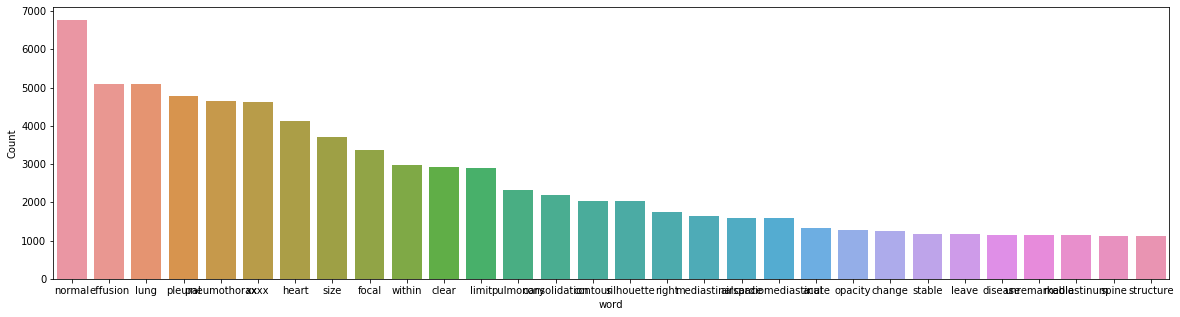

In [39]:
freq_words(df['Findings_lemmatized'])

In [40]:
df.columns

Index(['uId', 'parentImage_id', 'Comparison', 'Indication', 'Findings',
       'Impression', 'Major', 'Findings_no_punc', 'Major_no_punc',
       'Findings_no_stopwords', 'Findings_lemmatized'],
      dtype='object')

In [0]:
# save processed Findings df for LDA modeling
df[['uId', 'parentImage_id', 'Comparison', 'Indication', 'Findings',
       'Impression', 'Major', 'Findings_no_punc', 'Major_no_punc',
       'Findings_no_stopwords', 'Findings_lemmatized']].to_csv('/content/drive/My Drive/openI_processed.csv')

In [44]:
# useful attributes & methods: dictionary.token2id to get mapping, dictionary.num_docs 
df = pd.read_csv("/content/drive/My Drive/openI_processed.csv", index_col= 0)
Finds = df['Findings_lemmatized'].copy()
Finds = Finds.apply(lambda x: x.split())

# Dictionary expects a list of list (of tokens)
dictionary = corpora.Dictionary(Finds)
dictionary.filter_extremes(no_below=3)  # remove terms that appear in < 3 documents, memory use estimate: 8 bytes * num_terms * num_topics * 3

# number of terms
nd = dictionary.num_docs
nt = len(dictionary.keys())
print("number of documents", nd)
print("number of terms", nt)

# check some ids and tokens in the dictionary
for i in random.sample(range(nt),10):
    print(i, dictionary[i])

number of documents 6561
number of terms 999
644 though
565 centrilobular
946 number
97 leave
443 two
845 today
484 orient
7 tortuous
441 markedly
787 lob


##LDA Implementation on the Findings column

In [51]:
# Convert to array
docs =array(df['Findings_lemmatized'].astype(str))
print(type(docs))
print(len(docs))
# Define function for tokenize and lemmatizing
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs
# Perform function on our document
docs = docs_preprocessor(docs)
#Create Biagram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
#Remove rare & common tokens 
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

<class 'numpy.ndarray'>
6561


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Number of unique tokens: 663
Number of documents: 6561
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 3), (5, 1), (6, 1)]]


In [52]:
# Set parameters.
num_topics = 5
chunksize = 500 
passes = 20 
iterations = 400
eval_every = 1  

# Make a index to word dictionary.
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token
corpus = [dictionary.doc2bow(doc) for doc in docs]
lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 5 topics
print(lda_model.print_topics())

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


[(0, '0.041*"stable" + 0.032*"leave" + 0.030*"change" + 0.029*"calcify_granuloma" + 0.029*"spine" + 0.026*"thoracic" + 0.025*"mild" + 0.024*"opacity" + 0.021*"degenerative" + 0.018*"appear"'), (1, '0.061*"intact" + 0.049*"structure" + 0.030*"large" + 0.030*"evidence" + 0.029*"without" + 0.028*"trachea_midline" + 0.028*"chest_wall" + 0.026*"osseous" + 0.025*"vascular_congestion" + 0.024*"cardiac"'), (2, '0.030*"visible" + 0.028*"frontal_lateral" + 0.028*"typical_finding" + 0.027*"free_intraperitoneal" + 0.025*"unremarkable" + 0.025*"visualize" + 0.025*"bilaterally_specifically" + 0.024*"subsegmental_atelectasis" + 0.021*"nodule_masse" + 0.021*"atherosclerotic_calcification"'), (3, '0.097*"mediastinum" + 0.053*"lateral_view" + 0.036*"skeletal_structure" + 0.033*"unremarkable" + 0.028*"surgical_clip" + 0.025*"suggest_pneumonia" + 0.024*"lateral" + 0.020*"expand" + 0.020*"view" + 0.019*"interval"'), (4, '0.073*"acute" + 0.060*"bony" + 0.055*"soft_tissue" + 0.052*"abnormality" + 0.029*"prio

In [53]:
word_dict = {};
for i in range(num_topics):
    words = lda_model.show_topic(i, topn = 10)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05
0,stable,intact,visible,mediastinum,acute
1,leave,structure,frontal_lateral,lateral_view,bony
2,change,large,typical_finding,skeletal_structure,soft_tissue
3,calcify_granuloma,evidence,free_intraperitoneal,unremarkable,abnormality
4,spine,without,unremarkable,surgical_clip,prior_granulomatous
5,thoracic,trachea_midline,visualize,suggest_pneumonia,tissue
6,mild,chest_wall,bilaterally_specifically,lateral,soft
7,opacity,osseous,subsegmental_atelectasis,expand,vasculature
8,degenerative,vascular_congestion,nodule_masse,view,unremarkable
9,appear,cardiac,atherosclerotic_calcification,interval,disease


##Evaluating the LDA model

In [54]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda) 


Coherence Score:  0.36251913199157787


In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

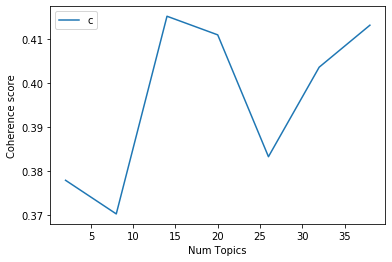

<Figure size 432x288 with 0 Axes>

In [57]:
#Model list and plot Coherence score against a number of topics
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
plt.savefig('/content/drive/My Drive/Graphs_And_Plots/Coherence score against a number of reports - OPenI(Findings)', dpi = 500)

In [58]:
lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
